## Toy Problem

We want to solve a simple PDE:
$$
    (a_\epsilon u')'(x) = 1, \quad  x\in [0,1], \qquad u(0)=u(1) = 0.
$$
where $a_\epsilon(x) = A(x, x/\epsilon)$ and $\epsilon = 1/N > 0$ for some integer $N$, and $A$ is periodic in the second argument.

in the special case when $a_\epsilon(x) = \mathrm{const} = \tilde a$, we have
$$
    \tilde u(x) = \frac{x(x-1)}{2\tilde a}.
$$
We parameterize 
$$
\tilde a = \frac{1}{(\phi \circledast a_\epsilon^{-1})(0)},
$$
where $\phi$ is an unknown convolutional kernel (the optimal $\phi$ according to homogenization is $1$). Then, the difference between $u$ and $\tilde u$ at a point $x$ is
$$
    u(x; a_\epsilon) - \tilde u(x; \tilde a) =  u(x; a_\epsilon) - \frac{x(x-1)}{2}(\phi \circledast a_\epsilon^{-1})(0)
$$
This is a specific PDE where $\tilde a$ is known. In general, we seek the optimal $\tilde a$ for cases when the optimal is not known.


In [4]:
import torch
from torch.fft import rfft, irfft
import matplotlib.pyplot as plt
from torch.nn.functional import conv1d

print("WARNING: N (number of disc points) MUST BE ODD")
inner = lambda phi_vec, afunc, eps: eps * torch.mean(phi_vec * afunc(torch.linspace(0, eps, len(phi_vec))))

def compute_ainv(a_vec, N):
    x = torch.linspace(0, 1, N)[:-1]
    return 1/a_vec(x)

def fft_pad(a, N):
    afft = torch.zeros(N)
    afft_ = rfft(a)
    afft[:len(afft_)] = afft_
    return afft

def pad(a, N):
    return torch.cat([a[-N:],a,a[:N]]) 

def conv(phi_vec, a_vec):
    Npad = (len(phi_vec)-1)//2
    a_vec_pad = pad(a_vec, Npad)
    ret = conv1d(a_vec_pad[None, None, :], phi_vec[None, None, :], bias=None, stride=1, padding=0).squeeze()
    #print(len(a_vec), len(a_vec_pad), len(ret), len(phi_vec))
    return ret
    
    
solve_constant = lambda x, aconst: x*(x-1)/(2 * aconst)
get_a_constant = lambda phi, afunc, eps: 1/inner(phi, lambda x: 1/afunc(x), eps) 

def get_a_variable(phi, ainv, eps): 
    N = len(ainv)
    vec = 1/conv(phi,ainv)#/(1/N*conv(phi, ainv))
    #print("Length of avec" , len(vec))
    return torch.cat([vec, torch.tensor([vec[0]])])



def solve_variable(afunc, N):
    x = torch.linspace(0, 1, N)
    return solve_variable_vec(afunc(x))


def solve_variable_vec(a):
    N = len(a)
    dx = 1/(N-1)
    A = (-2*torch.diag(a[1:-1], 0) + torch.diag(a[2:-1], -1) + torch.diag(a[1:-2], 1)) / dx**2
    b = torch.ones(N-2)
    return torch.cat([torch.tensor([0]), torch.linalg.solve(A, b), torch.tensor([0])])


def loss(atilde, usol, x):
    return torch.mean((usol - solve_constant(x, atilde))**2)

def loss_phi(phi, ainv, usol, x):
    ahom = get_a_variable(phi, ainv, eps)
    usol_hom = solve_variable_vec(ahom)
    return torch.mean((usol - usol_hom)**2)

def find_optimal_a(a0, usol, x):
    a = torch.tensor(a0, requires_grad=True)
    optimizer = torch.optim.Adam([a], lr=0.01)
    for i in range(500):
        optimizer.zero_grad()
        l = loss(a, usol, x)
        l.backward()
        optimizer.step()
        if i % 100 == 0:
            print(l)
    return a.item()

def symmetrize(phi):
    return (phi + torch.flip(phi, dims=(0,)))/2

Niter = 80000
def find_optimal_phi(phi0, afunc, usol, x):
    phi = torch.tensor(phi0, requires_grad=True)
    optimizer = torch.optim.Adam([phi], lr=0.05)
    for i in range(Niter):
        optimizer.zero_grad()
        l = loss_phi(phi, afunc, usol, x)
        l.backward()
        phi = phi - phi.grad * 0.05
        with torch.no_grad():
            phi = symmetrize(phi)
            phi /= torch.sum(phi)
        phi.requires_grad = True
        if i % 1000 == 0:
            print(f"Loss: {l.item():.2e}, iter: {i}/{Niter}", end="\r")
    return phi

atilde = 0.1
eps = 0.05
afunc = lambda x: atilde*(2 + torch.sin(2*torch.pi*x))*(1 + 0.9*torch.sin(x/eps*2*torch.pi))

N = 1001
x = torch.linspace(0, 1, N)
usol = solve_variable(afunc, N)
ainv = compute_ainv(afunc, N)

atilde_optimal = get_a_constant(torch.ones(200)/eps, afunc, eps).detach()
phi_learned = find_optimal_phi(torch.sin(3*torch.linspace(0, 2*torch.pi, 81)), ainv, usol, x)
atilde_learned = get_a_variable(phi_learned, ainv, eps).detach()
#atilde_learned = atilde #find_optimal_a(atilde)
print(f"Optimal a: {atilde_optimal}, Learned a: {atilde_learned}, Guess: {atilde}")


/tmp/ipykernel_409600/1021194775.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


Optimal a: 0.09656079858541489, Learned a: tensor([0.0826, 0.0809, 0.0797,  ..., 0.0882, 0.0850, 0.0826]), Guess: 0.1


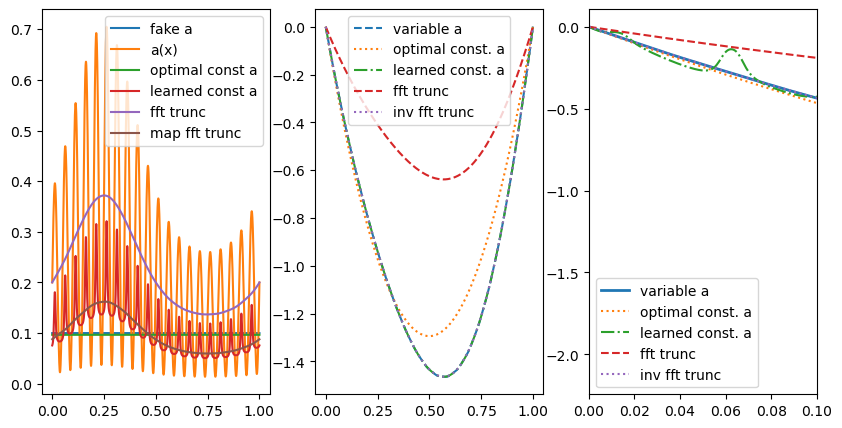

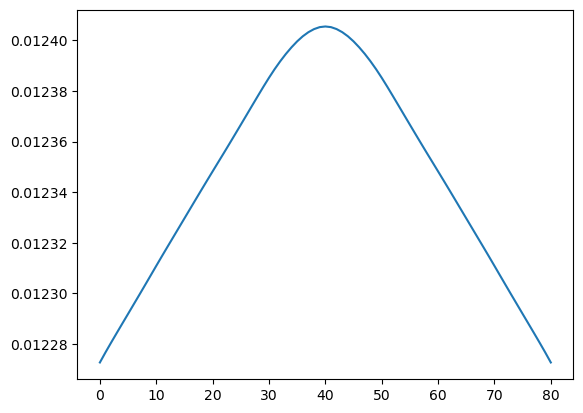

In [27]:
plt.figure(figsize=(10, 5))
afuncx = afunc(x)

def fft_trunc(a, Ntrunc):
    afft = rfft(a)
    N = len(a)
    return irfft(afft[:Ntrunc], N)


    
afuncx_trunc = fft_trunc(afuncx, 13)
afuncx2_trunc = 1/fft_trunc(1/afuncx, 13)
plt.subplot(131)
plt.plot(x, atilde*torch.ones_like(x), label="fake a")
plt.plot(x, afuncx, label="a(x)")
plt.plot(x, atilde_optimal*torch.ones_like(x), label="optimal const a")
plt.plot(x, atilde_learned*torch.ones_like(x), label="learned const a")
plt.plot(x, afuncx_trunc, label="fft trunc")
plt.plot(x, afuncx2_trunc, label="map fft trunc")
plt.legend()
plt.subplot(132)
plt.plot(x, solve_variable(afunc, N), '-', label="variable a",  linewidth=2)
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_variable_vec(atilde_learned), '-.', label="learned const. a")
plt.plot(x, solve_variable_vec(afuncx_trunc), '--', label="fft trunc")
plt.plot(x, solve_variable_vec(afuncx2_trunc), ':', label="inv fft trunc")
#plt.plot(x, solve_constant(x, atilde), label="fake const. a")
plt.legend()
plt.subplot(133)
plt.plot(x, solve_variable(afunc, N), '-', label="variable a", linewidth=2)
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_constant(x, atilde_learned), '-.', label="learned const. a")
plt.plot(x, solve_variable_vec(afuncx_trunc), '--', label="fft trunc")
plt.plot(x, solve_variable_vec(afuncx2_trunc), ':', label="inv fft trunc")
plt.xlim(0, 0.1)
plt.legend()

plt.figure()
plt.plot(phi_learned.detach())
#plt.ylim(0, 1/eps*3)

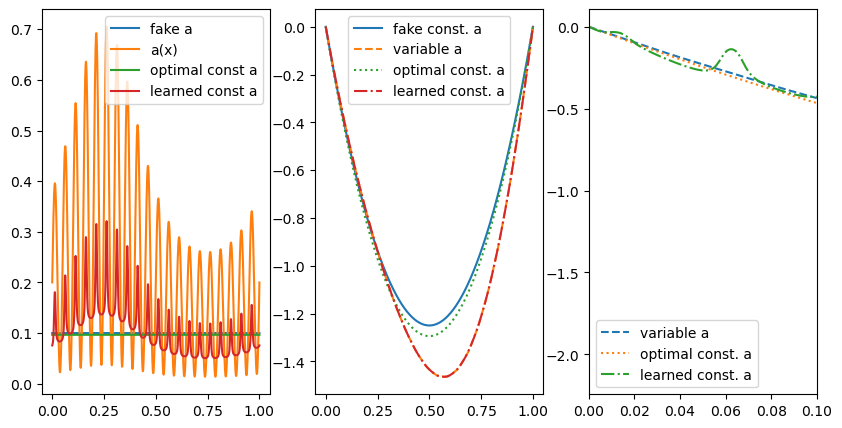

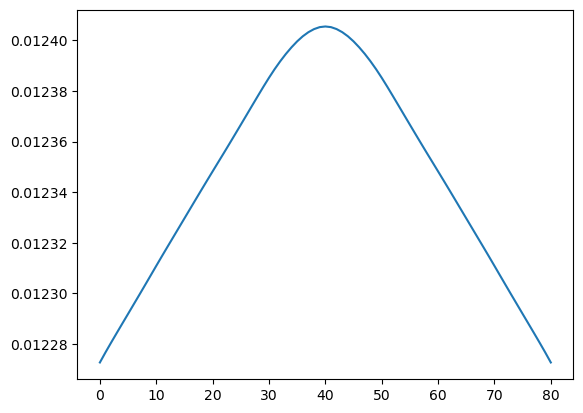

In [6]:
afunc = lambda x: atilde*(1 + torch.exp(torch.sin(2*torch.pi*x)))*(1 + 0.9*torch.sin(x/eps*2*torch.pi))

N = 2001
x = torch.linspace(0, 1, N)
usol = solve_variable(afunc, N)
ainv = compute_ainv(afunc, N)
atilde_learned = get_a_variable(phi_learned, ainv, eps).detach()


plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.plot(x, atilde*torch.ones_like(x), label="fake a")
plt.plot(x, afunc(x), label="a(x)")
plt.plot(x, atilde_optimal*torch.ones_like(x), label="optimal const a")
plt.plot(x, atilde_learned*torch.ones_like(x), label="learned const a")
plt.legend()
plt.subplot(132)
plt.plot(x, solve_constant(x, atilde), label="fake const. a")
plt.plot(x, solve_variable(afunc, N), '--', label="variable a")
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_variable_vec(atilde_learned), '-.', label="learned const. a")
plt.legend()
plt.subplot(133)
plt.plot(x, solve_variable(afunc, N), '--', label="variable a")
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_constant(x, atilde_learned), '-.', label="learned const. a")
plt.xlim(0, 0.1)
plt.legend()

plt.figure()
plt.plot(phi_learned.detach())
#plt.ylim(0, 1/eps*3)